# Random Forest

Чек лист для изучения модели:

1. Как формулируется задача математически

3. Желательно имплементировать модель самостоятельно через numpy (или torch)

4. Какие библиотеки содержат имплементации

5. Обучить на датасете

6. Как контролировать обучение модели

## Пункт 1

**Bagging**

Пусть у нас есть метод обучения $μ(x)$, тогда введём метод обучения $μ̃(x) = μ(x̃)$, где $x̃$ сгенерирована бутстрапом.

Сделаем следующее: построим композицию $a_n(x) = \frac{1}{N} Σ_{n=1}^{N} b_n(x) = \frac{1}{N} Σ_{n=1}^{N} μ̃(x)$ - бэггинг

Рассмотрим смещение $a_n(x)$:

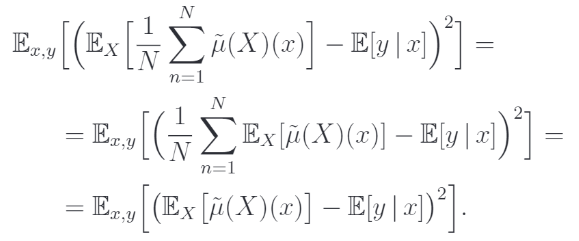

То есть смещение $a_n(x) = b_1(x)$. Если базовые модели были очень смещёнными, то композиция тоже будет такой, если смещение базовых моделей равно нулю, то у композиции тоже будет нулевое смещение. Отсюда вывод: базовые модели нуно брать с низким смещением (посложнее). Например: глубокие деревья

Рассмотрим разброс $a_n(x)$:

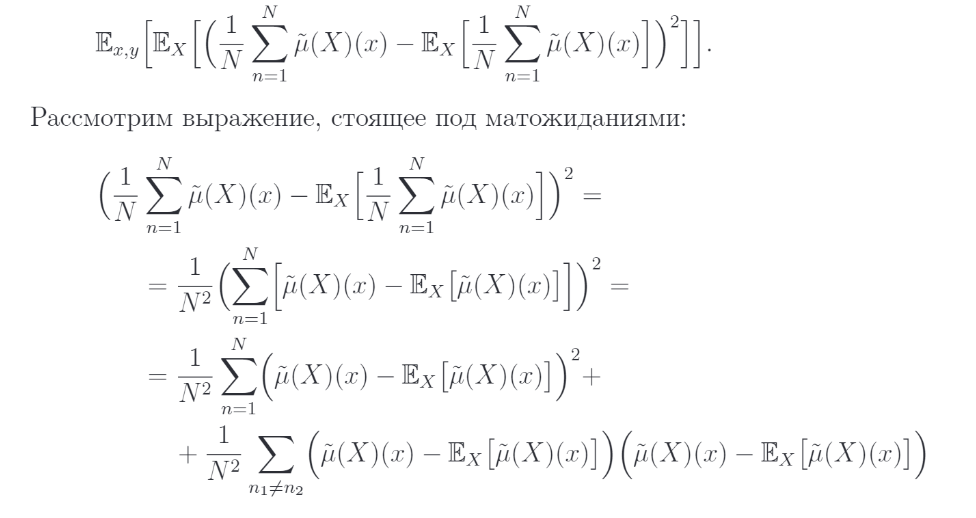

По простому это можно записать в следующем виде:

Разброс $a_n(x) = \frac{1}{N} (разброс \space b_1(x)) + COV(b_1(x), b_2(x))$

Вывод: надо строить некоррелированные базовые модели (они должны ошибаться по-разному).

Примечание: $b_i(x) = μ̃ (x)$

Как повышать разнообразие моделей:



1.   Обучать не на всех объектах (уже делаем)
2.   Обучать не на всех признаках - плохая идея (есть супер важные признаки, без которых ошибка высока, то есть смещение высокое у базовых моделей, а соответственно и наша композиция)
3.  При выборе лучшего предиката ограничить выбор признаков подмножеством $j ∈ J$ - Random Forest (случайный лес)



**Random Forest**

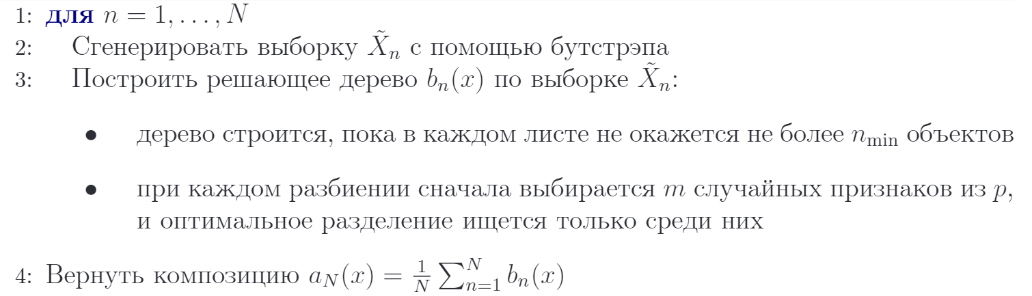

Рекомендации:


*   в задачах классификации брать $m = [\sqrt d]$
*   в задачах регрессии брать $m = [\frac{d}{3}]$

где d - число признаков

Также рекомендуется в задачах классификации строить дерево до тех пор, пока в каждом листе не окажется по 1 объекту, а в задачах регрессии - 5 объектов.



В итоге:

* в регресси усредняем ответы
* в классификации делаем голосование по большинству



Какие гиперпараметры есть в таком алгоритме: количество деревьев (по сути 1).

Как его выбирать:

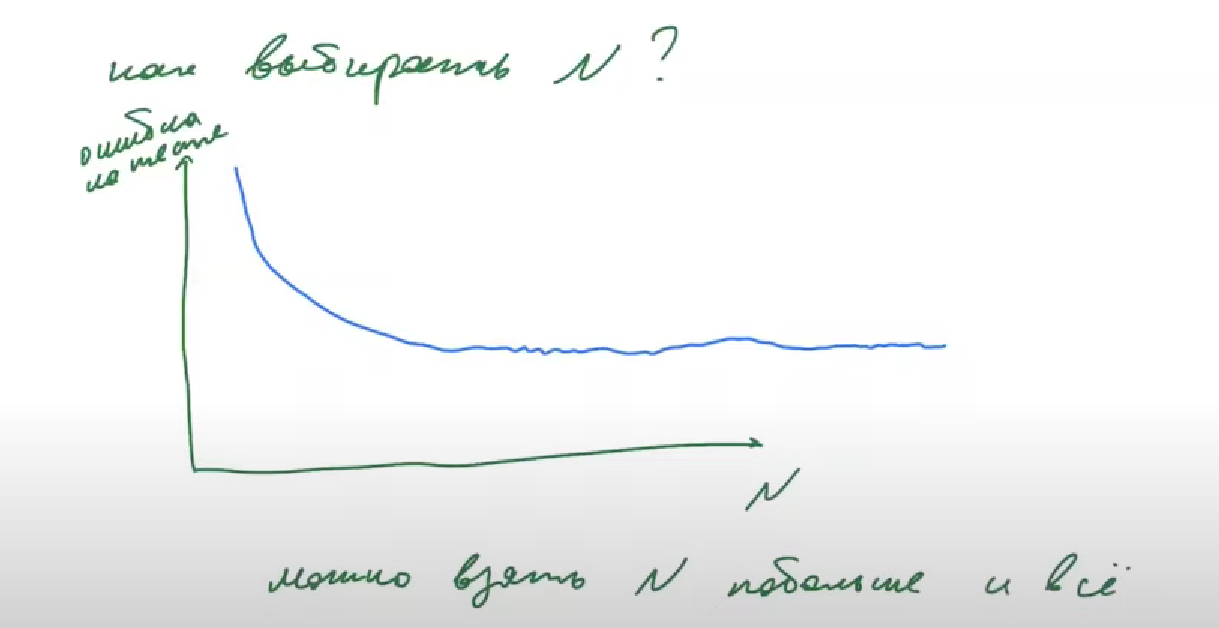

У RF нет существенных гиперпараметров!

Минусы:

1. Медленно обучается

2. Если дерево плохо подходит под задачу, то всё будет плохо

**Out-of-bag**

Для каждой базовой модели $b_i(x)$ есть тестовые объекты в обучающей выборке Х, то есть объекты, которые дерево не видело. Следовательно, мы можем найти для каждого объекта $x_i$ деревья, которые обучались без него,и вычислить по их ответам OOB-ошибку:

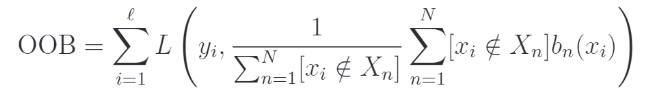



OOB $≈$ LOO

Leave-one-out - кросс-валидация с L блоками

Feature Importance

Как оценить, важен ли j-й признак для a(x)?



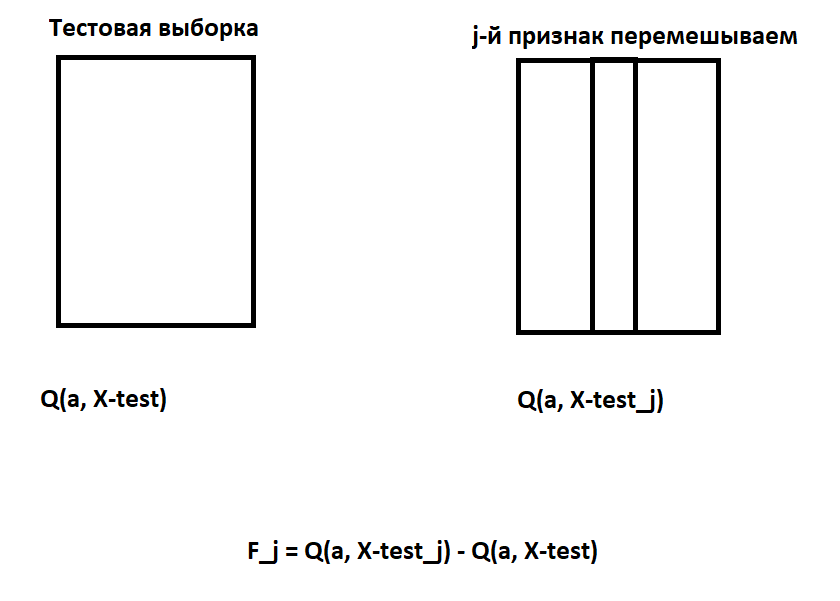

Если $F_j = 0$, признак неважен, если очень большое, то важный

## Пункт 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [3]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # проверка критерия остановы
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # находим лучший сплит
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # создаём поддеревья
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
        
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # считаем критерий информативности
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # энтропия предка
        parent_entropy = self._entropy(y)

        # энтропия потомков
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # взвешенная энтропия потомков
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # считаем информативность
        information_gain = parent_entropy - child_entropy
        return information_gain

    # разбиение на поддеревья
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    # энтропия
    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    # наиболее встречающийся класс
    def _most_common_label(self, y):
        if not(y.any()):
            y = np.append(y, 1)
        counter = Counter(y)
        #print(counter.most_common())
        value = counter.most_common(1)[0][0]
        return value

    # предсказание
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    # обход дерева
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [4]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

## Пункты 3-5

In [5]:
!wget -O "train.csv" -q "https://www.dropbox.com/s/ftutnnm0nfpzo5y/car_evaluation.csv?dl=0"

In [6]:
train = pd.read_csv('train.csv', header= None)

In [7]:
train.sample(3)

,0,1,2,3,4,5,6
1696,low,low,4,more,med,med,good
1172,med,med,5more,4,small,high,acc
1175,med,med,5more,4,med,high,vgood


In [8]:
train.isnull().any()

0    False
1    False
2    False
3    False
4    False
5    False
6    False
dtype: bool

In [9]:
train.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
6    object
dtype: object

In [10]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


train.columns = col_names

col_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [11]:
X = train.drop(['class'], axis=1)

y = train['class']

In [12]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import category_encoders as ce

In [14]:
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])


X = encoder.fit_transform(X)

In [15]:
X.sample(3)

,buying,maint,doors,persons,lug_boot,safety
1170,3,3,4,2,1,1
49,1,1,2,3,2,2
328,1,4,1,1,2,2


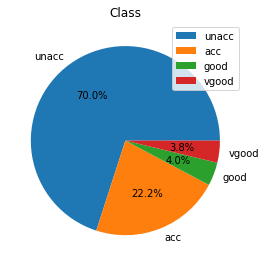

In [16]:
plt.figure(figsize =(20, 20))
data_i=y.value_counts()
plt.subplot(4,4,1)
plt.pie(data_i, labels = data_i.index, autopct='%1.1f%%')
plt.title('Class')
plt.legend()
None

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Sklearn Random Forest

In [19]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [20]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [21]:
print('f1_train = ', metrics.f1_score(y_train, train_pred, average='macro'))
print('f1_test = ', metrics.f1_score(y_test, test_pred, average='macro'))

print('recall_train = ', metrics.recall_score(y_train, train_pred, average='macro'))
print('recall_test = ', metrics.recall_score(y_test, test_pred, average='macro'))

print('precision_train = ', metrics.precision_score(y_train, train_pred, average='macro'))
print('precision_test = ', metrics.precision_score(y_test, test_pred, average='macro'))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  1.0
f1_test =  0.9028341355410089
recall_train =  1.0
recall_test =  0.9310467557065588
precision_train =  1.0
precision_test =  0.8865945231865744
accuracy_train =  1.0
accuracy_test =  0.9667250437828371


In [22]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

safety      0.294684
persons     0.239810
buying      0.163664
maint       0.150181
lug_boot    0.090393
doors       0.061268
dtype: float64

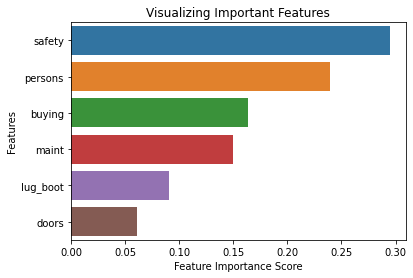

In [23]:
sns.barplot(x=feature_scores, y=feature_scores.index)

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')

plt.title("Visualizing Important Features")

plt.show()

In [24]:
X = train.drop(['class', 'doors'], axis=1)

y = train['class']

In [25]:
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'persons', 'lug_boot', 'safety'])


X = encoder.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [27]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [28]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [29]:
print('f1_train = ', metrics.f1_score(y_train, train_pred, average='macro'))
print('f1_test = ', metrics.f1_score(y_test, test_pred, average='macro'))

print('recall_train = ', metrics.recall_score(y_train, train_pred, average='macro'))
print('recall_test = ', metrics.recall_score(y_test, test_pred, average='macro'))

print('precision_train = ', metrics.precision_score(y_train, train_pred, average='macro'))
print('precision_test = ', metrics.precision_score(y_test, test_pred, average='macro'))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  0.9378642688301397
f1_test =  0.8500721500721501
recall_train =  0.9460660648023047
recall_test =  0.8818810653545
precision_train =  0.930524290582105
precision_test =  0.829228230347403
accuracy_train =  0.9688850475367329
accuracy_test =  0.9369527145359019


In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         acc       0.89      0.85      0.87       129
        good       0.64      0.90      0.75        20
       unacc       0.98      0.97      0.98       397
       vgood       0.80      0.80      0.80        25

    accuracy                           0.94       571
   macro avg       0.83      0.88      0.85       571
weighted avg       0.94      0.94      0.94       571



### My Random Forest

In [31]:
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'persons', 'lug_boot', 'safety'])


X = encoder.fit_transform(X)

encoder = ce.OrdinalEncoder(cols=['class'])


y = encoder.fit_transform(y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [33]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [34]:
clf = RandomForest(n_trees = 100)
clf.fit(X_train, y_train)

In [35]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [36]:
print('f1_train = ', metrics.f1_score(y_train, train_pred, average='macro'))
print('f1_test = ', metrics.f1_score(y_test, test_pred, average='macro'))

print('recall_train = ', metrics.recall_score(y_train, train_pred, average='macro'))
print('recall_test = ', metrics.recall_score(y_test, test_pred, average='macro'))

print('precision_train = ', metrics.precision_score(y_train, train_pred, average='macro'))
print('precision_test = ', metrics.precision_score(y_test, test_pred, average='macro'))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  0.9383653240982567
f1_test =  0.8443807209051111
recall_train =  0.952285812849125
recall_test =  0.8941291273700037
precision_train =  0.9262261882722642
precision_test =  0.8157611390601897
accuracy_train =  0.9688850475367329
accuracy_test =  0.9334500875656743


In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98       397
           2       0.91      0.82      0.86       129
           3       0.81      0.88      0.85        25
           4       0.56      0.90      0.69        20

    accuracy                           0.93       571
   macro avg       0.82      0.89      0.84       571
weighted avg       0.94      0.93      0.94       571

